# Evidence of bias in the Eurovision song contest

![Eurovision Basel 2025 logo](imgs/eurovision-basel.jpg)

## Modelling biased voting patterns using Bayesian hierarchical models

### with PyMC & ArviZ

![paper title: Evidence of Bias in the Eurovision song contest: modelling the votes using Bayesian hierarchical models](imgs/paper-title.png)

### Bayes' rule

- $P(H|E) = \frac{P(H)P(E|H)}{P(E)}$
- $P(H)$: _prior_; your beliefs before seeing any evidence
- $P(E|H)$: _likelihood_; probability of the evidence, given the hypothesis
- $P(E)$: _evidence_ or _average likelihood_; the probability of observing the evidence
- $P(H|E)$: _posterior_; **probability of the hypothesis, given the evidence**

![visual illustration of Bayes' rule, screenshotted from a 3Blue1Brown video](imgs/visual-bayes-rule.png)

### Bayesian models

- Statistical model: mathematical model that embodies a set of statistical assumptions concerning the generation of sample data ($x$)
    - Data generating process characterised by *parameters*; the set of all parameters is often called $\theta$ 
- Bayesian statistical model: estimate the posterior distribution of the parameters using Bayes' rule
    - In practice: draw samples from the posterior using an algorithm called "Markov Chain Monte Carlo"
- Bayes' rule, restated in terms of $\theta$ and $x$: $p(\theta|x) = \frac{p(\theta)p(x|\theta)}{p(x)}$
- Advantages:
    - Full posterior distributions for each parameter (different from traditional maximum likelihood estimation)
    - Interpretable(-ish) (depending on model complexity)

### Hierarchical models & Generalized Linear Models (GLMs)

- Hierarchical: a statistical model with multiple levels
- GLM:
    - Generalization of traditional linear regression
    - Arbitrary distribution of the response variable (Poisson, Normal, Beta, ...)
    - The linear model is linked to the response variable with a "link" function (this is what makes them "general")

### PyMC & ArviZ

- **PyMC** is a probabilistic programming library for Python that allows users to build Bayesian models with a simple Python API and fit them using Markov chain Monte Carlo (MCMC) methods.
- **ArviZ** is a Python package for exploratory analysis of Bayesian models

### Modelling Eurovision votes (1): data preprocessing and likelihood

> We define the voters as $v = 1, \ldots, V = 48$ and the performers as $p = 1, \ldots , P = 43$

- Label encoding.

> The outcome of interest is the variable $y_{v,p,t}$ representing the points given by voter $v$ to performer $p$ on occasion (year) $t = 1, \ldots , T_{v,p}$

- One data point (observation) for each unique combination of year, vote giver and vote receiver.

> Thus, $y_{v, p, t}$ is a categorical variable which can take any of the $S = 11$ values in the set of scores
$S = {0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12}$
> 
> We then model $y_{v,p,t} \sim Categorical(\mathbf{\pi}_{v,p,t})$, where $\mathbf{\pi}_{v,p,t} = (\pi_{v,p,t,1}, \ldots, \pi_{v,p,t,S}$) represents a vector of model probabilities that voter $v$ scores performer $p$ exactly $s \in S$ points on occasion $t$.

- Categorical likelihood for the number of points; the most general discrete distribution

### Modelling Eurovision votes (2): covariates and their preprocessing

> In addition to the main outcome, we observe some covariates defined at different levels ...
>
> - The year in which the contest is held as $x_{1,t}$.
>
> - The language in which a song is sung as $x_{2,p,t}$. This can take on the values _1 = English_, _2 = own_
and _3 = mixed_ (i.e. a combination of two or more languages).
>
> - The type of performance as $x_{3,p,t}$. This can take on the values _1 = Group_, _2 = Female solo artist_ or _3 = Male solo artist_.

- Label/ordinal encoding of categorical predictors.

### Modelling Eurovision votes (3): ordinal regression

> Following standard notation in ordinal regression, we model the cumulative probabilities $\eta_{v,p,t,s} = Pr(y_{v,p,t} \le s)$ as:
>
> <center>$logit(\eta_{v,p,t,s}) = \lambda_{s} − \mu_{v,p,t}$</center>
>
> with the obvious implication that $\pi_{v,p,t,1} = \eta_{v,p,t,1}$; $\pi_{v,p,t,s} = \eta_{v,p,s} − \eta_{v,p,t,(s−1)}$, for $s = 2, \ldots, S − 1$; and $\pi_{v,p,t,S} = 1 - \eta_{v,p,t,S}$.

> Here, $\mathbf{\lambda} = (\lambda_{1}, \ldots, \lambda_{S})$ is a set of random cutoff points for the latent continuous outcome associated with the observed categorical variable.

- $logit(x) = log \frac{x}{1-x}$ (also called _log odds_); maps values between 0 and 1 to between $-\infty$ and $+\infty$.
- Inverse logit or $expit(x) = \frac{e^{x}}{1+e^{x}}$; maps values between $-\infty$ and $+\infty$ to between 0 and 1.
- This is the "link function" that links our linear model to our likelihood function.

### Modelling Eurovision votes (4): cutpoints and linear model 

> In order to respect the ordering constraint implicit in the ordinal structure of the data, we model
> 
> <center>$\lambda_{1} \sim Normal(0, \sigma^{2}_{\lambda})$ with support $(-\infty,\lambda_{2})$</center>
> <center>$\lambda_{2} \sim Normal(0, \sigma^{2}_{\lambda})$ with support $(\lambda_{2},\lambda_{3})$</center>
> <center>$\ldots$</center>
> <center>$\lambda_{S-1} \sim Normal(0, \sigma^{2}_{\lambda})$ with support $(\lambda_{S-2},\lambda_{S})$</center>
> <center>$\lambda_{S} \sim Normal(0, \sigma^{2}_{\lambda})$ with support $(\lambda_{S-1},\infty)$</center>

> In addition, the linear predictor $\mu_{v,p,t}$ is defined as a function of the relevant covariates:
> <center>$\mu_{v,p,t} = \alpha_{v,p} + \beta_{1}x_{1},t + \beta_{2}x_{2,p,t} + \beta_{3}x_{3,t}$</center>

### Modelling Eurovision votes (5): modelling the structured effect $\alpha_{v,p}$

> The coefficient $\alpha_{v,p}$ is the parameter of main interest in our analysis and it represents a structured (random) effect, accounting for clustering at the voter–performer level.
>
> We use a formulation
> <center>$\alpha_{v,p} \sim Normal(\theta_{v,p}, \sigma_{\alpha}^{2})$</center>
>
> where the mean is specified as:
> <center>$\theta_{v,p} = \gamma + \delta_{R_{v}p} + \psi w_{v,p} + \phi z_{v,p}\mathbb{I}(z_{v,p})$</center>

> - $\gamma$ represents the overall intercept
> - covariate $w_{v,p}$ takes value 1 if countries share a geographic border $\ldots \psi$ is the ‘geographic’ effect
> - covariate $z_{v,p}$ represents an estimate of the migration intensity from country $v$ to country $p \ldots \phi$ is the ‘migration’ effect

### Modelling Eurovision votes (6): modelling geographic 'clusters'

> In addition, we assume that voters implicitly cluster in $K$ ‘regions’; this accounts for similarities in voters’ propensity towards the performers, over and above the geographic and migratory aspects defined above.

> For each voter we define a latent categorical variable $R_{v}$ which can take values $1, 2, \ldots\, K$ (for a fixed upper bound $K$), i.e. $R_{v} \sim Categorical(\mathbf{\zeta})$, where $\mathbf{\zeta} = (\zeta_{1}, \ldots , \zeta_{K})$ is the vector of probabilities that each voter belongs in each of the clusters.

> We use a minimally informative Dirichlet prior on $\mathbf{\zeta}$.

> Consequently, the coefficients $\delta_{k,p}$ (for $k = 1, \ldots , K$) represent a set of structured common residual for each combination of macro-area and performer, which we use to describe the ‘cultural’ effect.

- How to choose $K$?
    - They tried 3, 4, and 5, and chose the fitted model with the lowest Deviance Information Criterion (4 regions)

### Modelling Eurovision votes (6): priors

> We model the parameters in the linear predictor for $\theta_{v,p}$ using the following specification: $\gamma$, $\psi$ and $\phi$ are given independent minimally informative Normal distributions (centered on 0 and with large variance)

> $\delta_{k,p}$ are given an exchangeable structure:
> <center>$\delta_{k,p} \sim Normal(0, \sigma_{\delta}^{2})$</center>

> The two structured variances are given independent minimally informative prior on the log standard deviation scale:
> <center>$log(\sigma_{\alpha}), log(\sigma_{\delta}) \stackrel{iid}{\sim} Uniform(−3, 3)$</center>

- Very uninformative priors!
    - One benefit of 'regularizing' (narrower) priors is the prevention of overfitting; I'll use narrower ones than originally used

### Enough yapping, let's code

In [28]:
import pickle

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import xarray as xr

In [2]:
borders = pd.read_csv("data/borders.csv", index_col=0)
migrants_pivoted = pd.read_csv("data/migrants_pivoted.csv", index_col=0)
languages_pivoted = pd.read_csv("data/languages_pivoted.csv", index_col=0).astype(int)
votes = xr.open_dataset("data/votes.nc").points_encoded

In [3]:
borders.iloc[:5, :5]

,AL,AM,AT,AZ,BA
AL,1,0,0,0,0
AM,0,1,0,1,0
AT,0,0,1,0,0
AZ,0,1,0,1,0
BA,0,0,0,0,1


In [4]:
migrants_pivoted.iloc[:5, :5]

,AL,AM,AT,AZ,BA
from_country_id,,,,,
AL,-0.301651,-0.301651,-0.238721,-0.301651,-0.301651
AM,-0.301651,-0.301651,-0.257652,1.177712,-0.301651
AT,-0.301651,-0.301651,-0.301651,-0.301651,-0.294867
AZ,-0.301651,-0.301651,-0.301651,-0.301651,-0.301651
BA,-0.301651,-0.301651,1.937089,-0.301651,-0.301651


In [5]:
languages_pivoted.iloc[:5, :5]

,2015,2016,2017,2018,2019
country_id,,,,,
AL,0,0,0,1,1
AM,0,0,0,0,0
AT,0,2,0,0,0
AZ,0,0,0,0,0
BE,0,0,0,0,0


In [6]:
votes

<xarray.DataArray 'points_encoded' (voter: 43, performer: 42, year: 8)> Size: 116kB
[14448 values with dtype=float64]
Coordinates:
  * voter      (voter) object 344B 'AL' 'AM' 'AT' 'AZ' ... 'SE' 'SI' 'SM' 'UA'
  * performer  (performer) object 336B 'AL' 'AM' 'AT' 'AZ' ... 'SI' 'SM' 'UA'
  * year       (year) int32 32B 2015 2016 2017 2018 2019 2021 2022 2023

In [7]:
N_regions = 4
coords = {
    "voter": votes.coords["voter"].values,
    "performer": votes.coords["performer"].values,
    "year": votes.coords["year"].values,
    "points": tuple(range(11)),
    "region": tuple(range((N_regions))),
}

In [8]:
with pm.Model(coords=coords) as eurovision_model:
    x_1t = pm.Data("x_1t", list(range(len(coords["year"]))), dims="year")
    x_2pt_0 = pm.Data(
        "x_2pt_0",
        (languages_pivoted.astype(int) == 0).astype(int),
        dims=("performer", "year"),
    )
    x_2pt_1 = pm.Data(
        "x_2pt_1",
        (languages_pivoted == 1).astype(int),
        dims=("performer", "year"),
    )
    x_2pt_2 = pm.Data(
        "x_2pt_2",
        (languages_pivoted == 2).astype(int),
        dims=("performer", "year"),
    )
    w_vp = pm.Data(
        "w_vp",
        borders.loc[coords["voter"], coords["performer"]],
        dims=("voter", "performer"),
    )
    z_vp = pm.Data(
        "z_vp",
        migrants_pivoted.loc[coords["voter"], coords["performer"]],
        dims=("voter", "performer"),
    )
    observed = pm.Data(
        "votes",
        votes,
        dims=("voter", "performer", "year"),
    )

In [ ]:
with eurovision_model:
    # Hyperpriors
    σ_δ = pm.Exponential("σ_δ", 1)
    σ_α = pm.Exponential("σ_α", 1)
    σ_λ = pm.Exponential("σ_λ", 1)

    # Parameters
    δ_kp = pm.Normal("δ_kp", mu=0, sigma=σ_δ, dims=("region", "performer"))
    γ = pm.Normal("γ", mu=0, sigma=1, dims=("voter", "performer"))
    ψ = pm.Normal("ψ", mu=0, sigma=1)
    φ = pm.Normal("φ", mu=0, sigma=1)
    β_1 = pm.Normal("β_1", mu=0, sigma=1)
    β_2 = pm.Normal("β_2", mu=0, sigma=1, shape=3)  # For categories 0,1,2

    # Region membership priors
    ζ = pm.Dirichlet("ζ", np.ones(N_regions), dims="region")

    # Cutpoints for ordered logistic
    λ_s = pm.Normal(
        "λ_s",
        mu=0,
        sigma=σ_λ,
        shape=len(coords["points"]),
        transform=pm.distributions.transforms.ordered,
        initval=np.linspace(-2, 2, len(coords["points"])),
    )

In [12]:
with eurovision_model:
    # Region membership likelihood
    R_v = pm.Categorical("R_v", p=ζ, dims="voter")

    # Linear model for θ_vp
    θ_vp = γ + δ_kp[R_v, :] + ψ * w_vp + φ * z_vp

    # Prior for α_vp
    α_vp = pm.Normal("α_vp", mu=θ_vp, sigma=σ_α, dims=("voter", "performer"))

    # Linear model for μ_vpt
    μ_vpt = (
        α_vp[:, :, None]
        + β_1 * x_1t[None, None, :]
        + β_2[0] * x_2pt_0[None, :, :]
        + β_2[1] * x_2pt_1[None, :, :]
        + β_2[2] * x_2pt_2[None, :, :]
    )

    # Likelihood
    y_vpt = pm.OrderedLogistic(
        "y_vpt",
        eta=μ_vpt,
        cutpoints=λ_s,
        dims=("voter", "performer", "year"),
        observed=observed,
    )

_IncompleteInputError: incomplete input (1084460970.py, line 1)

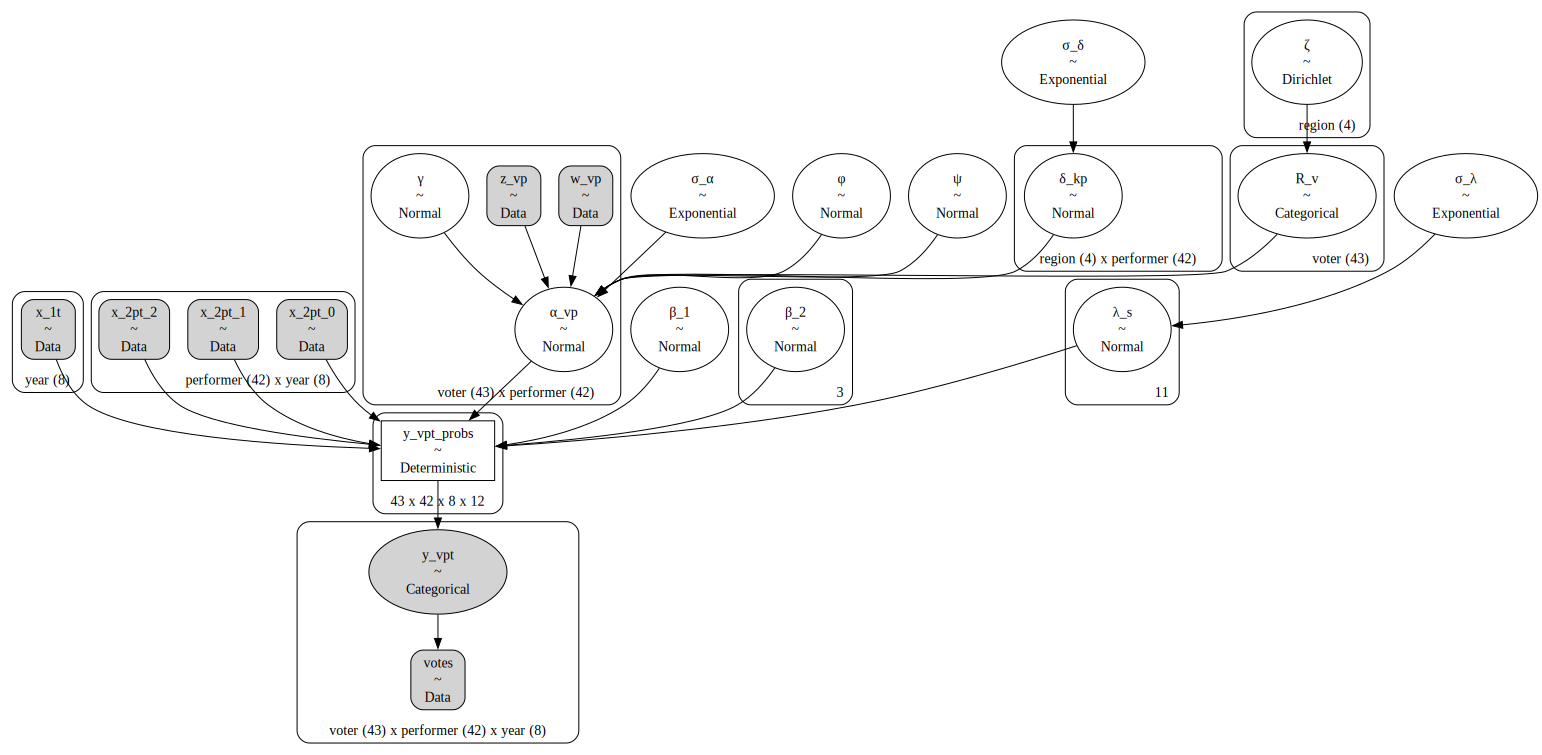

In [9]:
eurovision_model.to_graphviz()

In [10]:
with eurovision_model:
    idata = pm.sample(300, tune=200)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ_δ, σ_α, σ_λ, δ_kp, γ, ψ, φ, β_1, β_2, ζ, λ_s, α_vp]
>CategoricalGibbsMetropolis: [R_v]


Output()

Sampling 4 chains for 200 tune and 300 draw iterations (800 + 1_200 draws total) took 4318 seconds.
/home/max/miniforge3/envs/pymc/lib/python3.13/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [11]:
with open("data/eurovision_trace.pickle", "wb") as f:
    pickle.dump(idata, f, protocol=pickle.HIGHEST_PROTOCOL)

In [21]:
az.summary(idata, var_names=["ψ", "φ", "β_1", "β_2"], filter_vars="regex")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ψ,0.615,0.123,0.405,0.860,0.015,0.003,66.0,688.0,1.05
φ,0.157,0.046,0.071,0.246,0.002,0.001,680.0,870.0,1.01
β_1,-0.091,0.011,-0.111,-0.072,0.000,0.000,1618.0,895.0,1.01
β_2[0],-1.909,0.560,-2.957,-0.907,0.019,0.019,835.0,845.0,1.00
β_2[1],0.206,0.565,-0.788,1.297,0.020,0.020,829.0,716.0,1.01
β_2[2],-0.580,0.565,-1.571,0.493,0.020,0.019,825.0,769.0,1.00


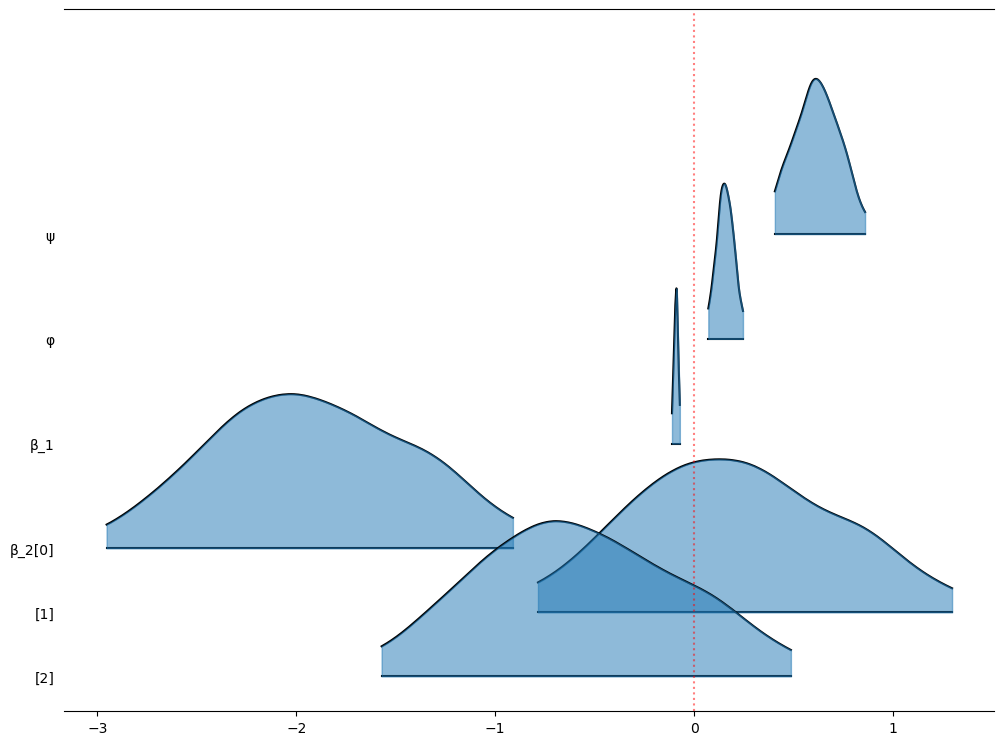

In [22]:
axes = az.plot_forest(
    idata,
    kind="ridgeplot",
    combined=True,
    var_names=["ψ", "φ", "β_1", "β_2"],
    ridgeplot_alpha=0.5,
)
axes[0].axvline(0, color="red", linestyle="dotted", alpha=0.5)

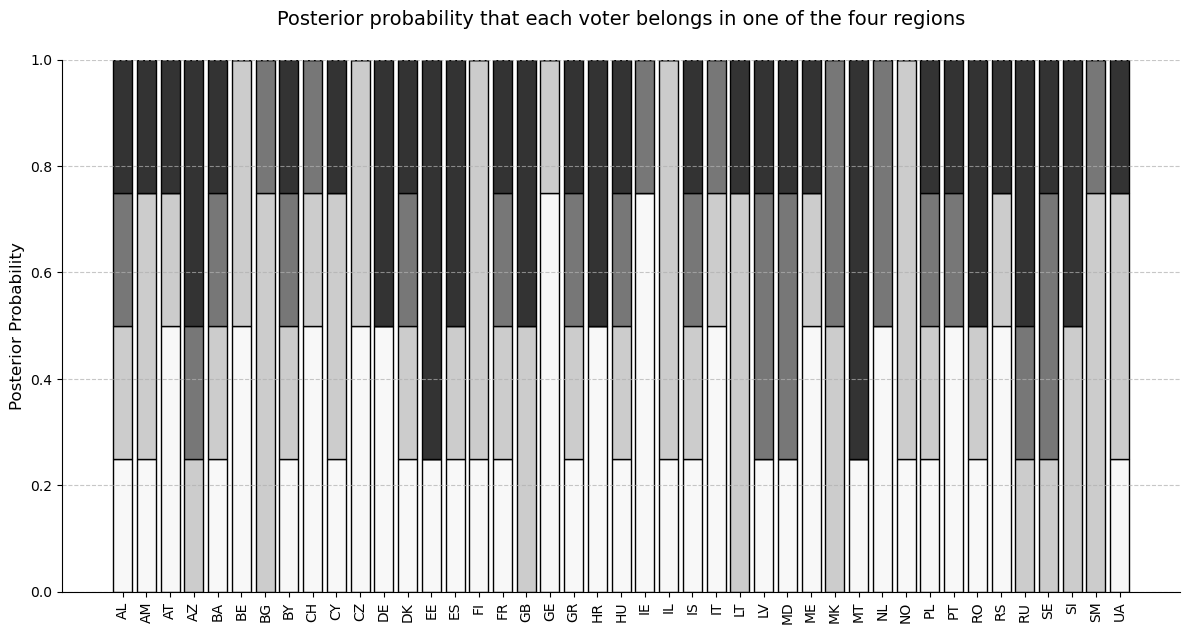

In [37]:
R_v_samples = idata.posterior["R_v"]
voters = coords["voter"]
N_voters = len(voters)
region_probs = np.zeros((N_voters, N_regions))

for v in range(N_voters):
    for r in range(N_regions):
        region_probs[v, r] = np.mean(R_v_samples[:, :, v] == r)

df = pd.DataFrame(
    region_probs, index=voters, columns=[f"Region {i+1}" for i in range(N_regions)]
)

fig, ax = plt.subplots(figsize=(12, 6))
bottom = np.zeros(N_voters)
colors = ["#f8f8f8", "#cccccc", "#777777", "#333333"]

for i, col in enumerate(df.columns):
    ax.bar(
        range(N_voters),
        df[col],
        bottom=bottom,
        color=colors[i],
        edgecolor="black",
        width=0.8,
    )
    bottom += df[col].values

ax.set_ylim(0, 1.0)
ax.set_ylabel("Posterior Probability", fontsize=12)
ax.set_xticks(range(N_voters))
ax.set_xticklabels(voters, rotation=90, fontsize=10)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.yaxis.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.title(
    "Posterior probability that each voter belongs in one of the four regions",
    fontsize=14,
    y=1.05,
)
plt.show()

![img](imgs/region-membership.png)

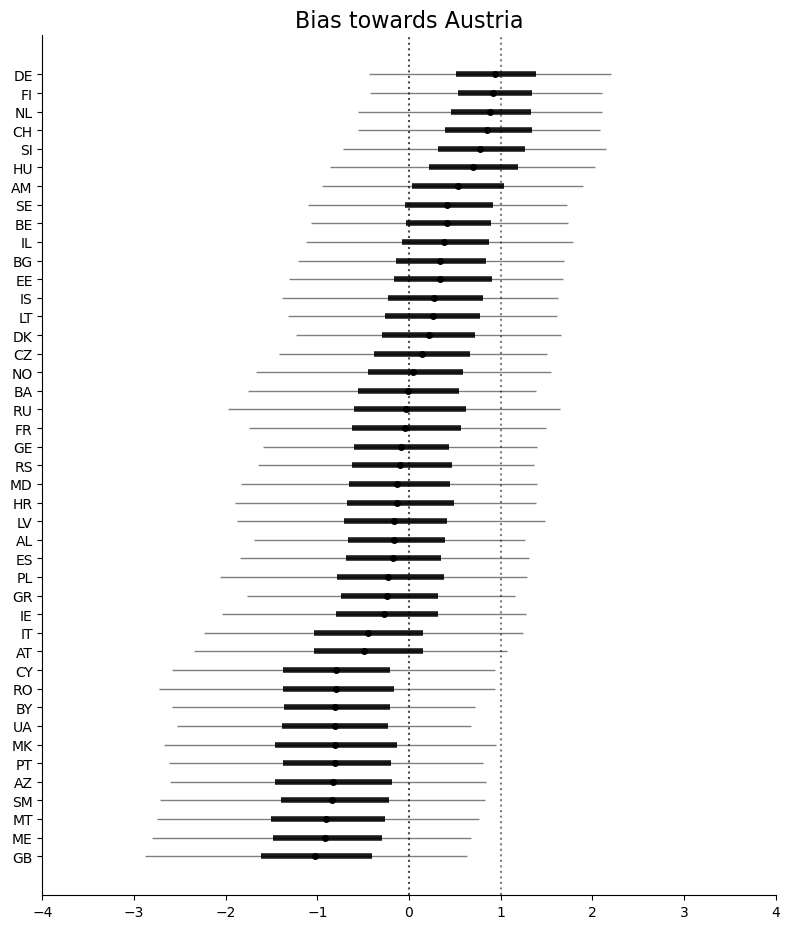

In [56]:
voters = list(coords["voter"])
alpha_samples = idata.posterior.α_vp[:, :, :, 2].values
n_chains, n_draws, n_voters = alpha_samples.shape
alpha_samples_reshaped = alpha_samples.reshape(n_chains * n_draws, n_voters)
means = np.mean(alpha_samples_reshaped, axis=0)
lower_95 = np.percentile(alpha_samples_reshaped, 2.5, axis=0)
upper_95 = np.percentile(alpha_samples_reshaped, 97.5, axis=0)
lower_50 = np.percentile(alpha_samples_reshaped, 25, axis=0)
upper_50 = np.percentile(alpha_samples_reshaped, 75, axis=0)
sorted_indices = np.argsort(means)
sorted_voters = [voters[i] for i in sorted_indices]
sorted_means = means[sorted_indices]
sorted_lower_95 = lower_95[sorted_indices]
sorted_upper_95 = upper_95[sorted_indices]
sorted_lower_50 = lower_50[sorted_indices]
sorted_upper_50 = upper_50[sorted_indices]
fig, ax = plt.subplots(figsize=(8, 10))
y_positions = range(len(sorted_voters))
ax.hlines(
    y=y_positions,
    xmin=sorted_lower_95,
    xmax=sorted_upper_95,
    color="black",
    alpha=0.5,
    linewidth=1,
)
ax.hlines(
    y=y_positions,
    xmin=sorted_lower_50,
    xmax=sorted_upper_50,
    color="black",
    alpha=0.9,
    linewidth=4,
)
ax.plot(sorted_means, y_positions, "o", color="black", markersize=4)
ax.axvline(x=0, color="black", linestyle=":", alpha=0.7)  # Zero line
ax.axvline(x=1, color="black", linestyle=":", alpha=0.5)  # Additional reference
ax.set_yticks(y_positions)
ax.set_yticklabels(sorted_voters)
data_min = min(sorted_lower_95)
data_max = max(sorted_upper_95)
padding = (data_max - data_min) * 0.1 
x_min = min(-3, np.floor(data_min - padding))
x_max = max(4, np.ceil(data_max + padding))
ax.set_xlim(x_min, x_max)
ax.set_xticks(range(int(x_min), int(x_max) + 1))
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_title(f"Bias towards Austria", loc="center", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

![img](imgs/austria-bias.png)

# Takeaways

- Full probability distributions > point estimates
- Interpretable > black box
- Creative aspect of it is fun
- Feasible for small to medium sized data sets (up to ~10⁴ observations)
- Sampling often annoyingly slow, only to fail at the end
- Handling dimensions and coordinates correctly can be a pain
- Accuracy tends to be worse than e.g. gradient-boosting trees, random forests, or neural networks
    - Doesn't always matter

# Sources and further reading

## Videos & animations

- [Visualizations of various Markov Chain Monte Carlo algorithms](https://github.com/chi-feng/mcmc-demo)
- [3Blue1Brown video on Bayes' rule](https://www.youtube.com/watch?v=HZGCoVF3YvM)

## Papers

- [The original 2014 paper replicated here](https://www.tandfonline.com/doi/full/10.1080/02664763.2014.909792)
- [A conceptional introduction to Hamiltonian Monte Carlo](https://arxiv.org/abs/1701.02434)
- [Bayesian workflow paper](https://arxiv.org/abs/2011.01808): sets out the proper workflow to follow

## Books

- [Statistical Rethinking](https://xcelab.net/rm/): probably the best educational resource to learn about this topic
- [Bayesian Methods for Hackers](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers)
- [Bayesian Modeling and Computation in Python](https://bayesiancomputationbook.com/welcome.html)
- [Bayesian Analysis with Python](https://bap.com.ar/)
- [Bayesian Data Analysis](https://www.stat.columbia.edu/~gelman/book/): heavy textbook by the leading author in the field
- [Modeling Mindsets: The Many Cultures Of Learning From Data](https://christophmolnar.com/books/modeling-mindsets/): very useful short book on all the different ML approaches